Fama-French Data with LQR and SplitCF. We only use monthly data. We randomly sample 80% as training and 20% as testing.

In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines

random_seed = 42

In [2]:
# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [3]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_lin,Y_lin,X_quantile,X_test):
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_lin))
            labels=Variable(torch.from_numpy(Y_lin))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_quantile = model(torch.from_numpy(X_quantile).float())
        M_quantile = M_quantile.detach().cpu().numpy().reshape(-1,1)
        M_test = model(torch.from_numpy(X_test).float())
        M_test = M_test.detach().cpu().numpy().reshape(-1,1)
        return M_quantile, M_test
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN2(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_lin))
            labels=Variable(torch.from_numpy(Y_lin))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_quantile = model(torch.from_numpy(X_quantile).float())
        M_quantile = M_quantile.detach().cpu().numpy().reshape(-1,1)
        M_test = model(torch.from_numpy(X_test).float())
        M_test = M_test.detach().cpu().numpy().reshape(-1,1)
        return M_quantile, M_test
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state=random_seed,criterion='squared_error')
        model.fit(X_lin, Y_lin)
        M_quantile = model.predict(X_quantile).reshape(-1,1)
        M_test = model.predict(X_test).reshape(-1,1)
        return M_quantile, M_test
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "squared_error")
        model.fit(X_lin, Y_lin)
        M_quantile = model.predict(X_quantile).reshape(-1,1)
        M_test = model.predict(X_test).reshape(-1,1)
        return M_quantile, M_test

In [4]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t,X_axis="X", Y_axis="Y",ylim=[-3,3]):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
         
         X_axis: name for the X axis
         Y_axis: name for the Y axis
    
    """
    
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.ylim(ylim)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='upper right')
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    bandwidth_med = np.median(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)
    print("The median bandwidth for testing data is", bandwidth_med)

In [5]:
# read the data
data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

In [25]:
# We set x = MKT, y = HML
X_axis = "MKT"
Y_axis = "HML"
X = MKT_te
Y = HML_te
# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]


# np.random.seed(2)
# np.random.shuffle(Data) # delete this line if we are doing time series data

/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/4186663847.py:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/4186663847.py:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


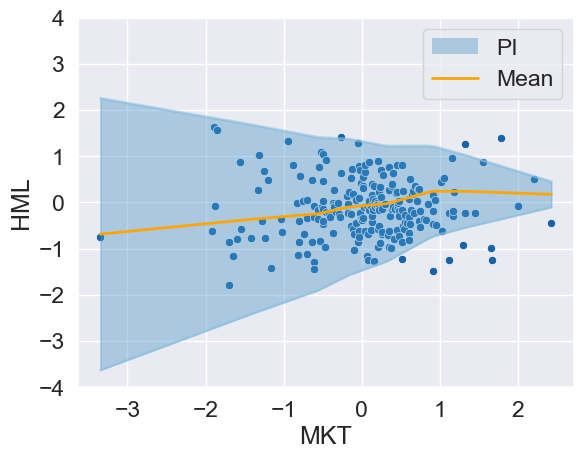

The overall coverage is 0.954337899543379
The mean bandwidth for testing data is 2.022875678330331
The median bandwidth for testing data is 1.7984851858497621


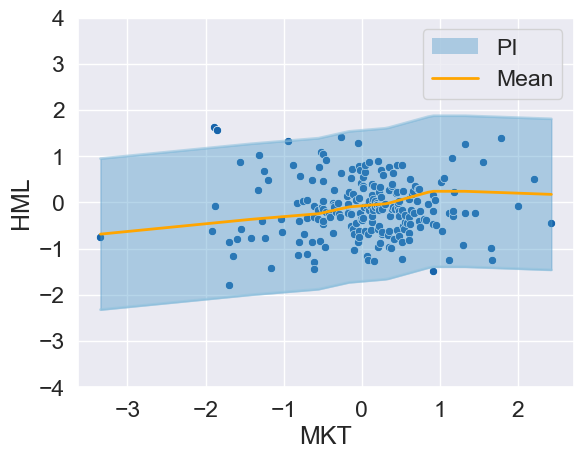

The overall coverage is 0.9863013698630136
The mean bandwidth for testing data is 2.6714815909598633
The median bandwidth for testing data is 2.6714815909598633


In [26]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


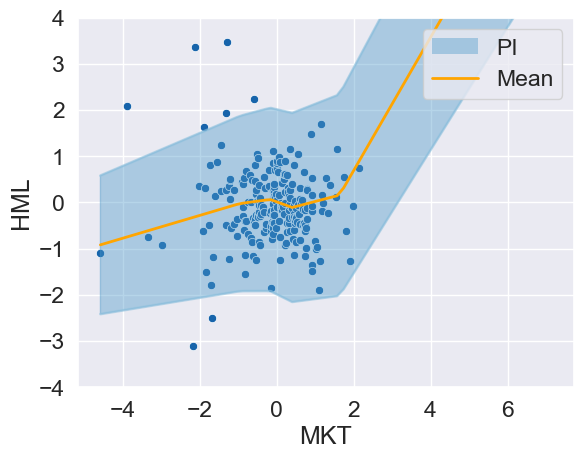

The overall coverage is 0.9655172413793104
The mean bandwidth for testing data is 3.979948978007147
The median bandwidth for testing data is 3.9840678050907243


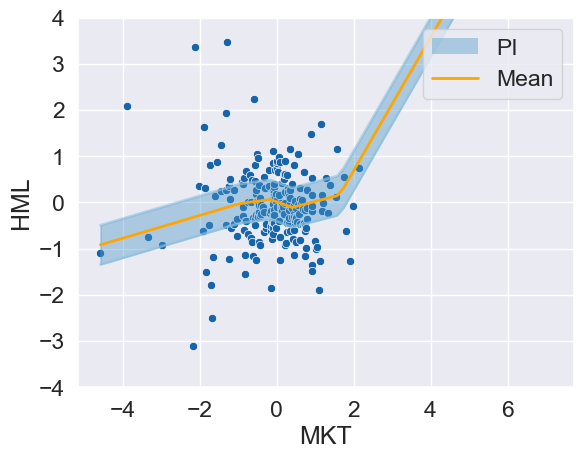

The overall coverage is 0.5043103448275862
The mean bandwidth for testing data is 0.1800671859659188
The median bandwidth for testing data is 0.18006718596591878


In [8]:
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

X_train = train_data[:,0].reshape(-1,1)
Y_train = train_data[:,1].reshape(-1,1)
y_train = Y_train[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
M_train, M_test = mean_est(est_type,X_train,Y_train,X_train,X_test)


# LQR
# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_train, Y_train-M_train)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



# SplitCF
y_train_pred = M_train[:,0]

# Calculate the conformity scores
residuals = np.abs(y_train - y_train_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

In [27]:
# We set x = MKT, y = SMB
X_axis = "MKT"
Y_axis = "SMB"
X = MKT_te
Y = SMB_te
# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]

# np.random.seed(1)
# np.random.shuffle(Data) # delete this line if we are doing time series data

/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/2071230590.py:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/2071230590.py:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


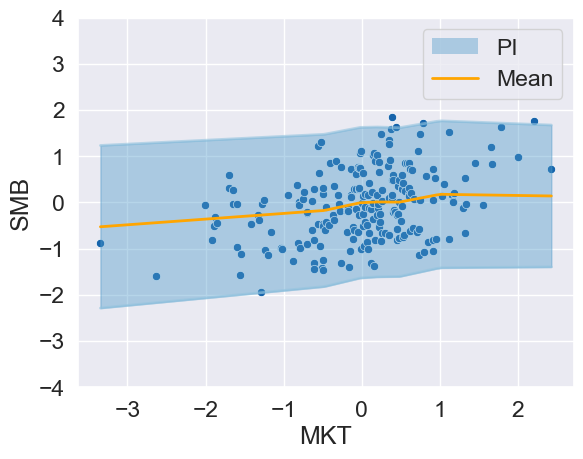

The overall coverage is 0.9823008849557522
The mean bandwidth for testing data is 2.6553709893787474
The median bandwidth for testing data is 2.642639891257123


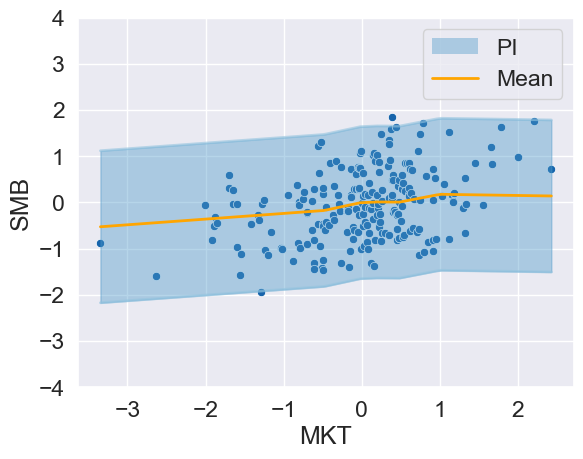

The overall coverage is 0.9911504424778761
The mean bandwidth for testing data is 2.707056373340561
The median bandwidth for testing data is 2.7070563733405613


In [28]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

In [21]:
# We set x = MKT, y = RF
X_axis = "MKT"
Y_axis = "RF"
X = MKT_te
Y = RF_te
cut = np.where((X<=1.5) & (X>=-1.5))[0]
X = X[cut,:]
Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]


# np.random.seed(10)
# np.random.shuffle(Data) # delete this line if we are doing time series data

/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/3355092824.py:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_47074/3355092824.py:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


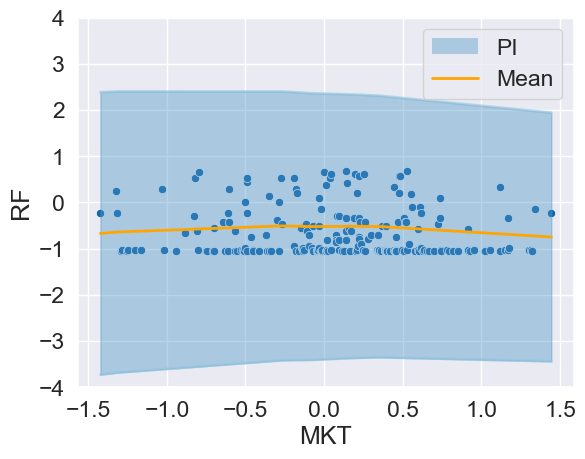

The overall coverage is 1.0
The mean bandwidth for testing data is 8.208405994734537
The median bandwidth for testing data is 8.1660617289174


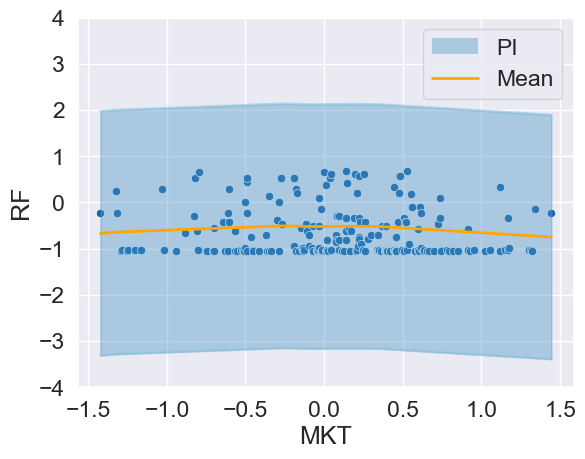

The overall coverage is 1.0
The mean bandwidth for testing data is 6.975137929401087
The median bandwidth for testing data is 6.97513792940109


In [22]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])